In [1]:
#Import the super mario game in the notebook
import gym_super_mario_bros

#Import the Joypad wrapper in the notebook
from nes_py.wrappers import JoypadSpace

#Import the simple controls so that the model just needs to control some movements of our agent (here Mario)
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
#Changes the game from colour image (RGB) to grayscale so that our processing becomes faster as we need to deal with less data 
from gym.wrappers import GrayScaleObservation, ResizeObservation   

#VecFrameStack allows us to work with our stacked enviroments by letting us know the information of previous frames. DummyVecEnv transforms our model so that we can pass it to our AI model. 
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

In [3]:
import gym
from gym.spaces import Box
import numpy as np


class SkipWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_stack=4, n_skip=2):
        super().__init__(env)
        self.n_stack = n_stack
        self.n_skip = n_skip
        self.height = 84
        self.width = 84

        self.observation_space = Box(
            low=0, high=255, shape=(self.height, self.width, self.n_stack), dtype=np.uint8
        )
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.uint8)

    def observation(self, obs):
        self.frame_stack[:,:,1:] = self.frame_stack[:,:,:-1] # shift frame_stack by 1
        self.frame_stack[:,:,0] = obs[:,:,0] # add current frame to stack
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

    def reset(self):
        obs = self.env.reset()
        obs = obs[:,:,0]
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.uint8)
        for i in range(self.frame_stack.shape[-1]):
            self.frame_stack[:,:,i] = obs
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeObservation(env, (84, 84))
# env = SkipWrapper(env, n_stack=4, n_skip=4)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, clip_obs=255, clip_reward=15)
env = VecFrameStack(env, 4)

In [5]:

# env = SkipWrapper(env, n_stack=4, n_skip=4)

In [6]:
state = env.reset()

In [7]:
state.shape

(1, 84, 84, 4)

In [8]:
state.shape

(1, 84, 84, 4)

In [9]:
states, rewards, dones, infos = env.step([env.action_space.sample()])

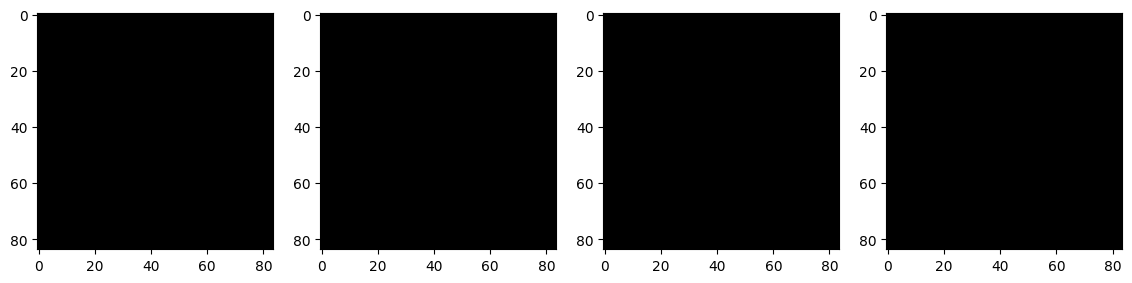

In [10]:
from matplotlib import pyplot as plt
import cv2

n_stack=4

fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    obs = states[0, :,:,i]
    obs = cv2.cvtColor(obs, cv2.COLOR_BGR2RGB)
    ax[i].imshow(obs)
plt.show()

In [11]:
def make_env(seed, env_name):
    def init():
        env = gym_super_mario_bros.make(env_name)
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = GrayScaleObservation(env, keep_dim=True)
        env = ResizeObservation(env, (84, 84))
        # env = SkipWrapper(env, n_stack=4, n_skip=4)
        env.seed(seed)

        return env
    return init

In [12]:
env = DummyVecEnv([make_env(0, "SuperMarioBros-1-1-v0")])
env = VecNormalize(env, clip_obs=255, clip_reward=15)
env = VecFrameStack(env, 4)

In [13]:
# Import os for file path management
import os

# Import PPO algorithm to train our model
from stable_baselines3 import PPO

# Import Base Callback for saving models and to continue from there
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
#Location of trained and logged files 
CHECKPOINT_DIR = './train/WithoutSkipWrapper/constant_learning'
LOG_DIR = './logs'
HPO_LOG_DIR = './opt_logs'
HPO_CHECKPOINT_DIR = './opt_train'

In [15]:
model = PPO.load(os.path.join(CHECKPOINT_DIR, 'model_2/best_model_5000100'), env)
# model = PPO.load(os.path.join(HPO_CHECKPOINT_DIR, 'trial_1_best_model'), env, tensorboard_log=LOG_DIR)

In [16]:
model.batch_size

64

In [18]:
# from stable_baselines3.common.evaluation import evaluate_policy

# mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1, render=True, deterministic=True)
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1, render=True, deterministic=False)

In [19]:
mean_reward

23.610414672642946

In [10]:
states = env.reset()

#Loop through the game
while True:
    # we are getting two values of which we need only one, so we put a underscore to just assign it the extra value
    actions, _ = model.predict(states, deterministic=False)
    states, rewards, dones, infos = env.step(actions)
    env.render()

In [ ]:
import imageio
import numpy as np

images = []
states = env.reset()
img = env.render(mode="rgb_array")

for i in range(10):
    done = False
    while done == False:
        img = np.copy(env.render(mode="rgb_array"))
        images.append(img)
        actions, _ = model.predict(states, deterministic=False)
        states, rewards, dones, infos = env.step(actions)
        done = dones[0]
        env.render()

gif = [img for i, img in enumerate(images) if i % 2 == 0]
imageio.mimsave("super_mario_bros_run.gif", gif, fps=30)

KeyboardInterrupt: 